# Strategy Backtesting Using Python (DMP-01)
#### Notebook Created on:  March 5th, 2019
##### Last Update: March 5th, 2019
##### Author: Xabier Mendoza, based on Vivek Krishnamoorthy's in-class notebook

In [1]:
# Libraries import

import pandas as pd
import numpy as np
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt

In [2]:
# I am using the csv read method, as I couldn't make Quandl API work

df = pd.read_csv("https://www.dropbox.com/s/2j6gft1h2rr21ul/MSFT.csv?dl=1", index_col=0, parse_dates=True)
# df = df.reindex(index=df.index[::-1])
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

### Q1: We'd created a list called 'wealth' in the modified Faber strategy. We also computed maWealth. Use the method cumprod() instead to get the same output. (Hint: You don't need to create maWealth).

**Solution**: I've created variables 'new_wealth' and 'w', keeping the original ones untouched, so you can see
 both calculation plotted in the chart. You will see the second one only, as overlaps, perfectly
 (hence, the same result has been calculated) with the previous one.

In [3]:
buyPrice = 0
sellPrice = 0
maWealth = 1.0
cash = 1
stock = 0
sma = 200

ma = np.round(df1['AdjClose'].rolling(window=sma, center=False).mean(), 2)
n_days = len(df1['AdjClose'])
closePrices = df1['AdjClose']
buy_data = []
sell_data = []
trade_price = []
wealth = []
new_wealth = [] #this new variable, to be used with 'cumprod()'

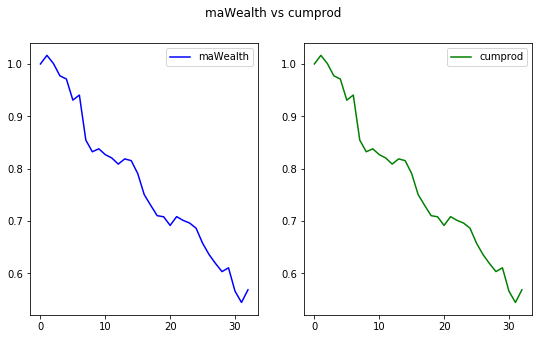

In [4]:
for d in range(sma-1, n_days):
    
    # Buy if stock price > MA & if not bought yet
    
    if closePrices[d] > ma[d] and cash == 1:
        buyPrice = closePrices[d + 1]
        buy_data.append(buyPrice)
        trade_price.append(buyPrice)
        cash = 0
        stock = 1
        
    # Sell if stock price < MA and if you have a stock to sell
    
    if closePrices[d] < ma[d] and stock == 1:
        sellPrice = closePrices[d + 1]
        sell_data.append(sellPrice)
        trade_price.append(sellPrice)
        cash = 1
        stock = 0
        
        maWealth = maWealth * (sellPrice / buyPrice)
        wealth.append(maWealth)
        new_wealth.append(sellPrice/buyPrice) # I append sell/buy, to be used as inputs for 'cumprod()' later

tp = pd.DataFrame(trade_price)
wealth.insert(0, 1)
new_wealth.insert(0,1)
w = pd.DataFrame(wealth)
new_w = pd.DataFrame(new_wealth).cumprod() # This is where I apply 'cumprod()'

fig, ax = plt.subplots(1,2, figsize=(9,5))
fig.suptitle('maWealth vs cumprod')

ax[0].plot(w, label='maWealth', color='b')
ax[1].plot(new_w, label='cumprod', color='g')
ax[0].legend()
ax[1].legend()

plt.show()

### Q2: The modified Faber's strategy has been implemented using 'for loop'. Implement the same strategy using dataframe.apply() method. 

**Solution**:I trim df removing first element, up to the SMA lenght, and apply a function I have called
'wealth_fun', to the resulting dataframe.

In [5]:
# Variables reinitialization

buyPrice = 0
sellPrice = 0
maWealth = 1.0
cash = 1
stock = 0
sma = 200
ma = np.round(df['AdjClose'].rolling(window=sma, center=False).mean(), 2)
n_days = len(df['AdjClose'])
df_sma=df[sma:n_days]
closePrices = df_sma['AdjClose']
buy_data = []
sell_data = []
trade_price = []
new_wealth = []

In [6]:
# definition of 'wealt_fun' function

def wealth_fun (d):
    
    global cash
    global stock
    global buyPrice
    global sellPrice
    global closePrices
    index = closePrices.index.get_loc(d) # I use 'get_loc' to locate the index of the close price date
    
    if closePrices[d] > ma[d] and cash == 1:
        buyPrice = closePrices[index + 1]
        buy_data.append(buyPrice)
        trade_price.append(buyPrice)
        cash = 0
        stock = 1
        
    if closePrices[d] < ma[d] and stock == 1:
        sellPrice = closePrices[index + 1]
        sell_data.append(sellPrice)
        trade_price.append(sellPrice)
        cash = 1
        stock = 0

        new_wealth.append(sellPrice / buyPrice)

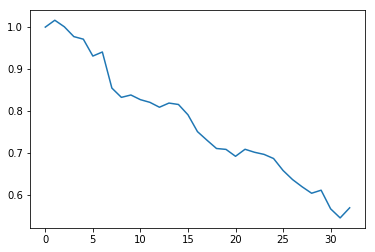

In [7]:
# 'wealth' calculation using 'apply' method

closePrices_Index = pd.Series(closePrices.index)
closePrices_Index.apply(wealth_fun)
tp = pd.DataFrame(trade_price)
new_wealth.insert(0,1)
new_w = pd.DataFrame(new_wealth).cumprod()
plt.plot (new_w)

### Q3: Write a customized function that computes returns for the modified Faber's strategy for different moving average durations. Try out different combinations to find one which is better than buy-and hold for any equity of your choice (except AAPL).

**Solution**:I defined a new function, called 'faber_sma' that iterates through a list of SMA periods, given as an input, and returns a DataFrame with the results (performance) for each one.

Then, I use this DF to compare those results with a buy and hold strategy, using the same MSFT stock data, and substract any SMA data with worse result that buy & hold.

In [8]:
def faber_sma (sma_list):
    
    ''' This function calculates modified Faber strategy, for a series of differente
    smas, from 'start' to 'end'. It returns a dictionary with the sma length as key, and the
    specific sma performance, as value.
    
    Args: sma, list of integers, with the different sma periods
    '''
    global closePrices
    global ma
    global buy_data
    global sell_data
    global trade_price
    global new_wealth
    global new_w
    global buyPrice
    global sellPrice
    global cash
    global stock
    buyPrice = 0
    sellPrice = 0
    cash = 1
    stock = 0
    
    performance = {}
    n_days = len(df['AdjClose'])
    
    for sma in sma_list:
       ma = np.round(df['AdjClose'].rolling(window=sma, center=False).mean(), 2)
       df_sma=df[sma:n_days]
       closePrices = df_sma['AdjClose']
       buy_data = []
       sell_data = []
       trade_price = []
       new_wealth = []
       new_w = []
       closePrices_Index = pd.Series(closePrices.index)
       closePrices_Index.apply(wealth_fun)
       new_wealth.insert(0,1)
       new_w = pd.DataFrame(new_wealth).cumprod()
       performance[sma]=new_w.iloc[len(new_w)-1]
       
    return performance

In [9]:
# Buy and hold performance, calculated as the difernce of last price with first one:

buy_hold = df['AdjClose'].iloc[len(df)-1]/df['AdjClose'].iloc[0]

In [10]:
# Please, enter SMA lengths of your choice in this list:

sma_list = [300,200,100,50,25] 

In [11]:
faber = pd.DataFrame.from_dict(faber_sma(sma_list)) # get a DF from the faber_sma's dictionary
better_than_bh = faber.where(faber>buy_hold).dropna(axis=1) # keep only SMAs with better performance

In [12]:
# This is the performance of buy and hold:

buy_hold

0.24557983290488433

In [13]:
# and these are the SMA's with better performance, from the sma_list selection:

faber

,25,50,100,200,300
0,1.062547,2.626851,2.008953,2.223766,0.601273


### Q4: The moving average crossover (MAC) code is implemented where we always have an open position. Calculate returns where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short selling, and the one we did in class. Comment on your results.


### Note: This part of the notebook, kept as in-class. Please, find Q4 answer below in-class code.

### Strategy # 2: The Moving Average Crossover Strategy

This is a well-known trading technique and considered to be the 'Hello World' of algorithmic/quantitative trading. It's essentially a way to take advantage of the momentum or trend in stock price movements.

We shall have two SMA filters viz. the shorter lookback period SMA (henceforth referred to as  'SMA50') and the longer lookback period SMA (henceforth referred to as 'SMA150'). We will go long on Microsoft *at the first instance* when the SMA50 exceeds the SMA150. Similarly, we will go short on Microsoft, *at the first instance* when the SMA150 exceeds the SMA50. This strategy can work well when the price movements of the asset trend in a particular direction (upwards or downwards) persistently before slowly reversing their drift.

Our trading rules can be stated as

* Go long when SMA50 > SMA150 on a given day and SMA50 < SMA150 on the previous day
* Go short when SMA50 < SMA150 on a given day and SMA50 > SMA150 on the previous day



```python

m = 50 # defining the shorter lookback period
n = 150 # defining the longer lookback period

df2['SMA50'] = df2['AdjClose'].rolling(window=m, center=False).mean()
df2['SMA150'] = df2['AdjClose'].rolling(window=n, center=False).mean()
```

We'll now plot the key variables and see how they look.
```python

df2[['AdjClose', 'SMA50', 'SMA150']].plot(grid=True, linewidth=0.5)
```

In [14]:
df2.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2018-03-27,94.940,95.139,88.51,89.47,53704562,0.0,1,94.940,95.139,88.51,89.47,53704562
2018-03-26,90.610,94.000,90.40,93.78,55031149,0.0,1,90.610,94.000,90.40,93.78,55031149
2018-03-23,89.500,90.460,87.08,87.18,42159397,0.0,1,89.500,90.460,87.08,87.18,42159397
2018-03-22,91.265,91.750,89.66,89.79,37578166,0.0,1,91.265,91.750,89.66,89.79,37578166
2018-03-21,92.930,94.050,92.21,92.48,23753263,0.0,1,92.930,94.050,92.21,92.48,23753263


In [15]:
df2.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'ExDividend'], axis=1, inplace=True)

```python

df2['SMA50_2'] = df2['AdjClose'].rolling(window=m, center=False).mean().shift(1)
df2['SMA150_2'] = df2['AdjClose'].rolling(window=n, center=False).mean().shift(1)
```

We've now computed all of what we need to generate trading signals. Let's go ahead and now do that.


In [16]:
m = 50 # defining the shorter lookback period
n = 150 # defining the longer lookback period

df2['SMA50'] = df2['AdjClose'].rolling(window=m, center=False).mean()
df2['SMA150'] = df2['AdjClose'].rolling(window=n, center=False).mean()

df2['SMA50_2'] = df2['AdjClose'].rolling(window=m, center=False).mean().shift(1)
df2['SMA150_2'] = df2['AdjClose'].rolling(window=n, center=False).mean().shift(1)

In [17]:
df2['Signal'] = np.where((df2['SMA50'] > df2['SMA150']) 
                        & (df2['SMA50_2'] < df2['SMA150_2']), 1, 0)
df2['Signal'] = np.where((df2['SMA50'] < df2['SMA150']) 
                        & (df2['SMA50_2'] > df2['SMA150_2']), -1, df2['Signal'])


In [18]:
df2.head()

,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume,SMA50,SMA150,SMA50_2,SMA150_2,Signal
Date,,,,,,,,,,,
2018-03-27,1,94.940,95.139,88.51,89.47,53704562,NaN,NaN,NaN,NaN,0
2018-03-26,1,90.610,94.000,90.40,93.78,55031149,NaN,NaN,NaN,NaN,0
2018-03-23,1,89.500,90.460,87.08,87.18,42159397,NaN,NaN,NaN,NaN,0
2018-03-22,1,91.265,91.750,89.66,89.79,37578166,NaN,NaN,NaN,NaN,0
2018-03-21,1,92.930,94.050,92.21,92.48,23753263,NaN,NaN,NaN,NaN,0


In [19]:
df2['Buy'] = df2.apply(lambda x : x['AdjClose'] if x['SMA50'] > x['SMA150'] 
                        and x['SMA50_2'] < x['SMA150_2'] else 0, axis=1)

df2['Sell'] = df2.apply(lambda y : -y['AdjClose'] if y['SMA50'] < y['SMA150'] 
                        and y['SMA50_2'] > y['SMA150_2'] else 0, axis=1)

df2['TP'] = df2['Buy'] + df2['Sell']
df2['TP']=df2['TP'].replace(to_replace=0, method='ffill')

df2['Position'] = df2['Signal'].replace(to_replace=0, method= 'ffill')
k = df2['TP'].nonzero()

type(k) # this tells us k is a tuple

k[0] #this gives us a numpy array
type(k[0]) #confirms that this is a numpy ndarray
len(k[0]) # total number of positions

frame = df2.iloc[k]

In [20]:
frame.head()

,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume,SMA50,SMA150,SMA50_2,SMA150_2,Signal,Buy,Sell,TP,Position
Date,,,,,,,,,,,,,,,
2015-12-14,1,51.734055,52.572008,51.115113,52.505352,47006491,50.396719,50.359496,50.330473,50.369432,1,52.505352,0.0,52.505352,1
2015-11-12,1,52.095898,52.467263,51.429345,51.476956,39549497,50.427054,50.360860,50.396719,50.359496,0,0.000000,0.0,52.505352,1
2015-10-12,1,52.743407,52.995745,52.381564,52.629141,31775826,50.494626,50.364303,50.427054,50.360860,0,0.000000,0.0,52.505352,1
2015-09-12,1,52.724363,53.200472,51.905454,52.352997,36373209,50.560126,50.367580,50.494626,50.364303,0,0.000000,0.0,52.505352,1
2015-08-12,1,52.819584,53.419482,52.362519,53.124295,32878026,50.612860,50.375741,50.560126,50.367580,0,0.000000,0.0,52.505352,1


In [21]:
df2['Signal'].value_counts()
# In the period, we've chosen, this is in line with what we see in k

 0    2444
 1       7
-1       6
Name: Signal, dtype: int64

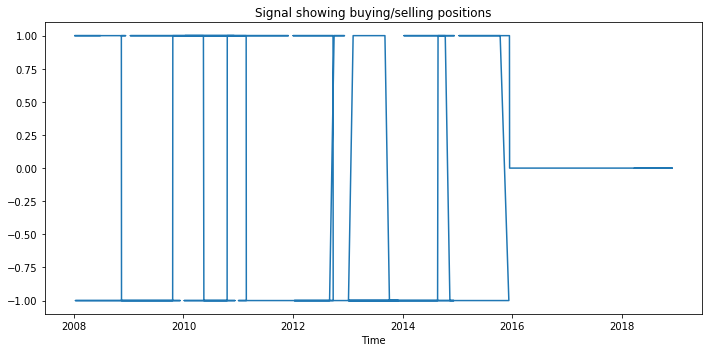

In [22]:
# Alternate way to plot the graph
plt.figure(figsize=(10, 5))
plt.plot(df2['Position'])
plt.title("Signal showing buying/selling positions")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

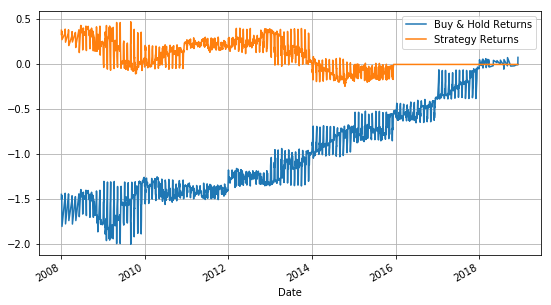

In [23]:
df2['Buy & Hold Returns'] = np.log(df2['AdjClose'] / df2['AdjClose'].shift(1))
df2['Strategy Returns'] = df2['Buy & Hold Returns'] * df2['Position'].shift(1)

df2[['Buy & Hold Returns', 'Strategy Returns']].cumsum().plot(grid=True, figsize=(9,5))


### Q4's answer starts here:

In [24]:
# I am using the same 'Buy' info we already calculated

# df2['TP_long_only'] = df2['Buy']
# df2['TP_long_only'] = df2['TP_long_only'].replace(to_replace=0, method='ffill')

# and removing the 'Sell' signals

df2['Long Only Signal']=df2['Signal'].replace(-1, 0)

# calculating a new position: 'Position_LO', for long-only strategy

df2['Position_LO'] = df2['Long Only Signal']



In [25]:
# checking if the DF contains long signals only:

df2['Long Only Signal'].value_counts()

0    2450
1       7
Name: Long Only Signal, dtype: int64

In [26]:
k = df2['Long Only Signal'].nonzero()

# adding up all the buy signals: I consider every BUY, as additional leverage in our position, otherwaise, the
# performance of this strategy would be equal to the Buy and Hold. 

for item in reversed(range(len(k[0])-1)):
    df2['Position_LO'].iloc[k[0][item]] += df2['Position_LO'].iloc[k[0][item+1]]

# I print dates where the buy signal occurs:

for i in range(len(k[0])):
    print('item',i,df2.iloc[k[0][i]].name, df2['Position_LO'].iloc[k[0][i]])
    
first_signal = df2.iloc[len(k[0])-1].name

item 0 2015-12-14 00:00:00 7
item 1 2014-10-12 00:00:00 6
item 2 2013-09-05 00:00:00 5
item 3 2012-09-24 00:00:00 4
item 4 2011-02-23 00:00:00 3
item 5 2010-05-14 00:00:00 2
item 6 2008-11-13 00:00:00 1


/anaconda3/envs/ipykernel_py3/lib/python3.5/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
df2['Position_LO'].value_counts()

0    2450
7       1
5       1
3       1
1       1
6       1
4       1
2       1
Name: Position_LO, dtype: int64

In [28]:
# I replace zeros between signals, with the corresponding leverage (cum buy signals)

df2['Position_LO']=df2['Position_LO'].replace(to_replace=0, method= 'bfill')


In [29]:
df2['Position_LO'].value_counts()

7    574
5    401
3    400
1    376
6    254
2    196
4    155
0    101
Name: Position_LO, dtype: int64

In [30]:
df2['Buy & Hold Returns'] = np.log(df2['AdjClose'] / df2['AdjClose'].shift(1))
df2['Strategy Returns'] = df2['Buy & Hold Returns'] * df2['Position'].shift(1)

# Adding 'Long Only Strategy Returns' to the DF

df2['Long Only Strategy Returns'] = df2['Buy & Hold Returns'] * df2['Position_LO'].shift(1)


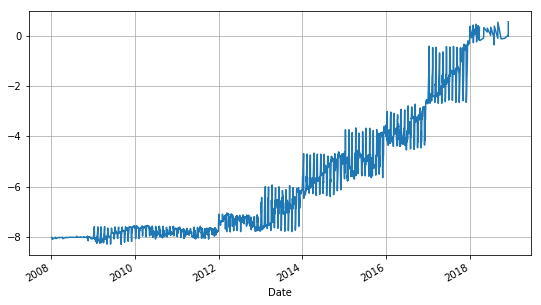

In [31]:
df2['Long Only Strategy Returns'].cumsum().plot(grid=True, figsize=(9,5))

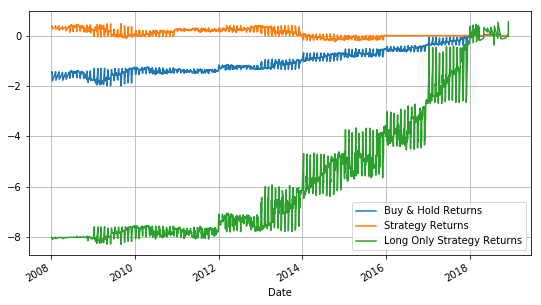

In [32]:
# Plotting the three strategies toguether

df2[['Buy & Hold Returns', 'Strategy Returns', 'Long Only Strategy Returns']].cumsum().plot(grid=True, figsize=(9,5))

### Q5: Download the data for any 5 stocks (using the code for automatically downloading multiple stocks) of your choice for the last 5 years.


In [45]:

import pandas_datareader.data as web
from concurrent import futures


In [56]:
def download_stocks(stock):
    try:
        print('Trying to retrieve the %s symbol...\n' % (stock))
        stock_df = web.DataReader(stock, 'quandl', start, end)
        stock_df['Name'] = stock
        output_name = stock + '.csv'
        list_stocks.append(output_name)
        stock_df.to_csv(output_name)
        print('Symbol %s downloaded OK.\n' % (stock))
    except:
        bad_tickers.append(stock)
        print('Problems downloading the %s symbol.\n' % (stock))

In [112]:
stocksList = ['IBM', 'FB', 'HP', 'TSLA', 'AMZN']
list_stocks = []

### Keeping track of failed ticker download queries
bad_tickers = []

end = datetime.datetime.now().date()
start = end - pd.Timedelta(days = 365 * 5)

# We use the concurrent.futures module's ThreadPoolExecutor 
# to speed up the downloads by doing them in parallel rather than serially
    
### Set the maximum thread number
max_workers = 50

workers = min(max_workers, len(stocksList)) 
### In case a smaller number of stocks than threads was passed in
with futures.ThreadPoolExecutor(workers) as executor:
    res = executor.map(download_stocks, stocksList)
### map allows multiple calls to the given function. It passes each of the items in stocksList (any 
### iterable) to the function. Here, it can happen concurrently because of the ThreadPoolExecutor()
### subClass

Trying to retrieve the IBM symbol...

Trying to retrieve the FB symbol...
Trying to retrieve the HP symbol...


Trying to retrieve the TSLA symbol...

Trying to retrieve the AMZN symbol...

Symbol FB downloaded OK.

Symbol IBM downloaded OK.

Symbol HP downloaded OK.

Symbol AMZN downloaded OK.
Symbol TSLA downloaded OK.




### For the above mentioned time period:

#### a) Compute the daily returns (assuming you buy at open and sell at close) everyday. 

In [115]:
# I saved .csv files in Dropbox, to avoid environment (path) issues when you check this notebook
# I am loading .csv files into a DF

stock_data = pd.DataFrame()
TSLA = pd.read_csv("https://www.dropbox.com/s/ubggtcj1agyuut5/TSLA.csv?dl=1", index_col=0, parse_dates=True)
IBM = pd.read_csv("https://www.dropbox.com/s/33p38bwiimd6h0g/IBM.csv?dl=1", index_col=0, parse_dates=True)
HP = pd.read_csv("https://www.dropbox.com/s/4ycwpqfbh9zf7xn/HP.csv?dl=1", index_col=0, parse_dates=True)
FB = pd.read_csv("https://www.dropbox.com/s/4rjf3oq0g6ou13m/FB.csv?dl=1", index_col=0, parse_dates=True)
AMZN = pd.read_csv("https://www.dropbox.com/s/eev62573c08c82q/AMZN.csv?dl=1", index_col=0, parse_dates=True)
stock_data = pd.DataFrame(((((stock_data.append(TSLA)).append(IBM)).append(HP)).append(FB)).append(AMZN))

In [116]:
# checking if all stocks data was appended:

stock_data['Name'].value_counts()

IBM     1020
HP      1020
FB      1020
TSLA    1020
AMZN    1019
Name: Name, dtype: int64

In [140]:
# Daily returns for each stock

stock_returns = pd.DataFrame()
HP['Daily Returns']=np.log(HP['AdjOpen']/HP['AdjClose'])
stock_returns['HP Returns']=HP['Daily Returns']
FB['Daily Returns']=np.log(FB['AdjOpen']/FB['AdjClose'])
stock_returns['FB Returns']=FB['Daily Returns']
AMZN['Daily Returns']=np.log(AMZN['AdjOpen']/AMZN['AdjClose'])
stock_returns['AMZN Returns']=AMZN['Daily Returns']
IBM['Daily Returns']=np.log(IBM['AdjOpen']/IBM['AdjClose'])
stock_returns['IBM Returns']=IBM['Daily Returns']
TSLA['Daily Returns']=np.log(TSLA['AdjOpen']/TSLA['AdjClose'])
stock_returns['TSLA Returns']=TSLA['Daily Returns']      

# note: this methos is not very efficiente, nor dynamice, but I couldn't find the way to call a DF using a variable
# (based on the list of stocks), instead the name. i.e.: instead of IBM['Returns'], use stock['Returns']
# where 'stock' is an iterable (a list of names).


#### b) Compute the hit ratio for each of them. 

In [189]:
hit_ratios={}
hit_ratios['TSLA HR']= stock_returns['TSLA Returns'][stock_returns['TSLA Returns'] > 0].count()
hit_ratios['HP HR'] = stock_returns['HP Returns'][stock_returns['HP Returns'] > 0].count()
hit_ratios['IBM HR'] = stock_returns['IBM Returns'][stock_returns['IBM Returns'] > 0].count()
hit_ratios['AMZN HR'] = stock_returns['AMZN Returns'][stock_returns['AMZN Returns'] > 0].count()
hit_ratios['FB HR'] = stock_returns['FB Returns'][stock_returns['FB Returns'] > 0].count()

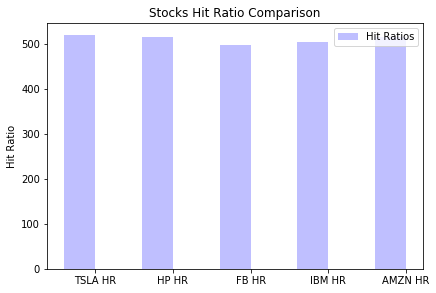

In [219]:
fig, ax = plt.subplots()
stocks = len(stocksList)
index = np.arange(stocks)
bar_width = 0.4
opacity = 0.25
ax.bar(index, hit_ratios.values(), bar_width,
                alpha=opacity, color='b',
                label='Hit Ratios')
ax.set_xticklabels(hit_ratios.keys())
ax.set_xticks(index + bar_width / 2)
ax.legend()
fig.tight_layout()
ax.set_ylabel('Hit Ratio')
ax.set_title('Stocks Hit Ratio Comparison')

plt.show()

#### c) Compute the cumulative returns for each of them.

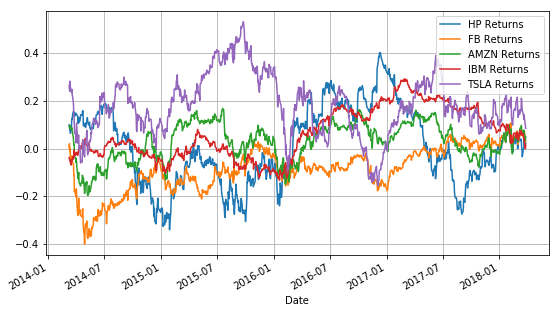

In [143]:
# cumulative returns charted

stock_returns[['HP Returns','FB Returns', 'AMZN Returns','IBM Returns','TSLA Returns']].cumsum().plot(grid=True, figsize=(9,5))

Although each stock shows a different behaviour for the period 2014-2018, all of them show similar results for the complete analyzed period, probably driven by sector momentum.

TSLA certanly shows much more volatily, compared to the rest, and FB shows a pretty steady path, considerig the environment this company has had to navigate through.